In [126]:
from numpy import *
import pyfftw
from IPython.display import display, Markdown, Math
from matplotlib.pyplot import *

In [127]:
#Fonction a tester et pour laquelle on recherche la solution à l'equation de Poisson (somme de 2 sinus)
def f(x,y):
    return sin(x)+sin(y)

#Particularité de la fonction testée f : la solution a l'equation de Poisson est la meme à une constante près
def solu(x,y):
    return sin(x)+sin(y)

In [128]:
TYPE = "complex128"
#On choisit la taille de la grille de résolution de l'equation de Poisson : grille carrée de taille 128*128.
N = 128
#Intervalle suivant l'axe x et y pour lequel on considere la fonction f et la solution recherchée.
L = 2*np.pi 

#Création de numpy arrays x et y, remplis par un "decoupage" de maniere equitable de l'intervalle [-pi;pi] avec
#N elements.  
x,y = np.linspace(-np.pi, +np.pi, N, dtype=TYPE), np.linspace(-np.pi, np.pi,N, dtype=TYPE)
#Création de matrices au sens de numpy, correspondant a la grille des valeurs sur l'axe x et sur l'axe y pour
#chaque point.
X,Y = np.meshgrid(x, y)

In [129]:
#Matrice prenant pour elements les valeurs de f sur tous les points de la grille
in1 = pyfftw.empty_aligned((N,N), dtype=TYPE)
#Matrice prenant pour elements la FFT des valeurs de f contenus dans in1
out1 = pyfftw.empty_aligned((N,N ), dtype=TYPE)
#Matrice comprenant les elements solution de l'equation de Poisson dans l'espace de Fourier (avant FFT inverse)
in2 = pyfftw.empty_aligned((N,N ), dtype=TYPE)
#Matrice prenant pour elements la FFT inverse des valeurs de in2
out2 = pyfftw.empty_aligned((N,N ), dtype=TYPE)

In [130]:
#Utilisation de la methode FFTW pour créer un object fft_object_2d, les arguments considérés sont en entrée in1, 
#out1 pour obtenir la forme de la sortie (la FFT), ainsi que les axes 0 et 1 correspondant aux axes de
#réalisation de la FFT sur out1, (implicite : direction ='FFTW_FORWARD', flags='FFTW_MEASURE')
fft_object_2d = pyfftw.FFTW(in1, out1, axes=(0,1))
#Utilisation de la methode FFTW pour créer un object ifft_object_2d, les arguments considérés sont en entrée in2,
#out2 pour obtenir la forme de la sortie (la FFT inverse) etc..
ifft_object_2d = pyfftw.FFTW(in2, out2, axes=(0,1), direction="FFTW_BACKWARD")

In [131]:
#Sol est une matrice au sens de numpy des elements de la solution connue de la resolution de l'equation de
#Poisson pour f afin de comparer avec le resultat de la FFT
sol=zeros((N,N))

for i in range(N):
    for j in range(N):
        #in1 prend les valeurs de f
        in1[i][j]=f(X[i][j],Y[i][j])
        #sol prend les valeurs de la solution connue, (.real) peut etre retiré plus tard si complexes désirés
        sol[i][j]=solu(X[i][j].real,Y[i][j].real)


In [132]:
#Execution de la FFT stockés dans out1
out1 = fft_object_2d(int1)

In [133]:
#Edition de in2 correspondant à la solution de l'equation de Poisson dans l'espace de Fourier
for i in range(N):
    for j in range(N):
        #Initialisation de fact a chaque boucle sur i et j
        fact = 0
        
        in2[i][j]=0
        in2[i][j]=0
        
        #fact est un element par quoi on divise out1 pour obtenir in2 
        #qui prend pour valeur i*i + j*j uniquement si 2*i < N et 2*j< N sinon les elements de la somme
        #sont respectivement remplacés (N-i) et (N-j) si 2*i> N et 2*j>N. Cette stratégie permet de prendre
        #en considération des vecteurs d'ondes negatifs. En effet, pour un index i donné, sont associés les 
        #vecteurs d'ondes (2pi/L)*i/N et (2pi/L)*(i-N)/N.
        
        #Il s'agit donc de considerer les vecteurs d'ondes (2pi/L)*i/N pour la 1ere partie 
        if (2*i<N):
            fact = i*i
        #Et les les vecteurs d'ondes (2pi/L)*(i-N)/N pour la 2nd partie 
        else :
            fact = (N-i)*(N-i)
        if (2*j<N):
            fact = fact + j*j
        else :
            fact = fact + (N-j)*(N-j)
        #Remarque dans (2pi/L)*(i-N)/N, le i est en fait valide à 1 dimension, il faut PROBABLEMENT 
        #adapter le terme ecrit a 2d en considerant i et j.
        
        #Pour le "vecteur d'onde" nul correspondand à la moyenne sur le spectre, on choisit délibérement
        #de fixer les elements in2 a 0 afin d'éviter une division par 0. C'est équivalent a ne pas considerer cette fréquence dans la résolution.
        if (fact == 0):
            in2[i][j]=0+1j*0
        #Dans le cas ou le "vecteur d'onde" obtenu n'est pas nul, on effectue la division
        else :
            in2[i][j]=out1[i][j]/fact
            
#fact n'est en realité pas un vecteur d'onde, il n'a pas d'unité et FFTW necessite justement des arguments sans
#unité. Il faudra par la suite retablir les unités par des mises en facteur si on souhaite extraire des fréquences ou autre.

In [134]:
#On execute la FFT inverse a partir de in2 pour obtenir la solution de l'equation de Poisson
out2 = ifft_object_2d(in2)

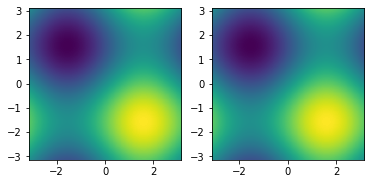

In [135]:
figures,ax = subplots(1,2)
stretch = (-np.pi, +np.pi, -np.pi, +np.pi)
#Solution obtenue à partir de la resolution de l'equation de Poisson par FFT
ax[0].imshow(out2.real,extent=stretch),\
#Solution connue afin d'effectuer une comparaison
ax[1].imshow(sol,extent=stretch)
show()


In [136]:
length=len(in2)
#Permet d'obtenir les frequences de la FFT a l'aide de la methode fftfreq de la classe fft du module de numpy.
#Les arguments en entrée sont la longueur du signal d'entrée (la taille de in2 stockée dans length) et l'intervalle
#entre chaque elements du signal de la grille c'est a dire L/N ou L=2*pi
freq=fft.fftfreq(length,L/N)

#Reordonne les fréquences de la plus petite a la plus grandes (des valeurs negatives en fréquences aux valeurs
#positives), c'est à dire en physique des cycles par metre ou des cycles par minutes
freq_reorder = np.fft.fftshift(freq)

#Preciser ce que fait réellement fftfreq : multiplier par le facteur 2*pi permetrai de passer d'un nombre d'onde a un vecteur d'onde
#ou d'une frequence a une pulsation
freq_test = (1/L)*np.arange(-N/2,N/2)

print(freq_reorder)
print(freq_test)

[-10.18591636 -10.02676141  -9.86760647  -9.70845153  -9.54929659
  -9.39014164  -9.2309867   -9.07183176  -8.91267681  -8.75352187
  -8.59436693  -8.43521198  -8.27605704  -8.1169021   -7.95774715
  -7.79859221  -7.63943727  -7.48028233  -7.32112738  -7.16197244
  -7.0028175   -6.84366255  -6.68450761  -6.52535267  -6.36619772
  -6.20704278  -6.04788784  -5.88873289  -5.72957795  -5.57042301
  -5.41126807  -5.25211312  -5.09295818  -4.93380324  -4.77464829
  -4.61549335  -4.45633841  -4.29718346  -4.13802852  -3.97887358
  -3.81971863  -3.66056369  -3.50140875  -3.3422538   -3.18309886
  -3.02394392  -2.86478898  -2.70563403  -2.54647909  -2.38732415
  -2.2281692   -2.06901426  -1.90985932  -1.75070437  -1.59154943
  -1.43239449  -1.27323954  -1.1140846   -0.95492966  -0.79577472
  -0.63661977  -0.47746483  -0.31830989  -0.15915494   0.
   0.15915494   0.31830989   0.47746483   0.63661977   0.79577472
   0.95492966   1.1140846    1.27323954   1.43239449   1.59154943
   1.75070437   1.

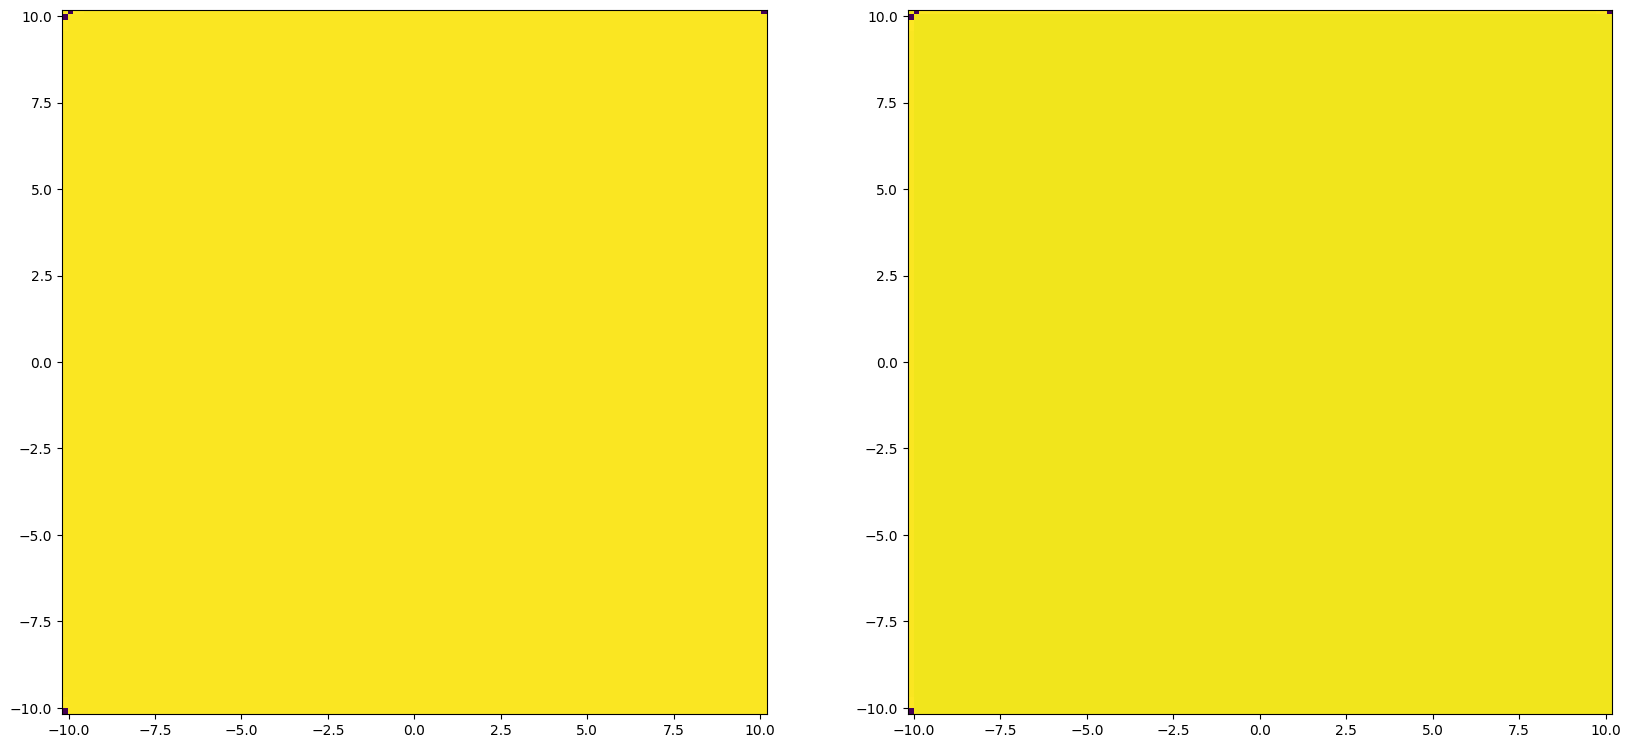

In [182]:
#Representation d spectre de la TF en utlisant les valeurs des fréquences

fig,ax = subplots(1,2)

fig.set_size_inches(20, 20, forward=True)
fig.set_dpi(100)
stretch2 = (-(1/L)*N/2, (1/L)*N/2, -(1/L)*N/2, (1/L)*N/2)
in3=in2*10**5
ax[0].imshow(in2.real,extent=stretch2)
ax[1].imshow(out1.real,extent=stretch2)
fig.savefig('test2png.png', dpi=100)
show()



In [ ]:
help(pyfftw.FFTW)